In [1]:
# importing necessary packages
import numpy as np
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

/home/rohit/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rohit/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rohit/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rohit/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [2]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

Using TensorFlow backend.


In [3]:
# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
# data augmenatation to increase variance in data
def speedNpitch(data):
    '''
    Speed and Pitch Tuning.
    '''
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

In [5]:
# we prepare data in this function, where if the data size is larger than the expected value then we randomly cut 
# the extra part in the beginning or at the end and if the size of the data is small then do padding at the start and 
# at the end. We can mention the featurisation technique and if augmentation for the data is needed ot not.

def prepare_data(df, n, aug, mfcc):
    '''
    Extracting the MFCC feature in matrix format
    '''
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate, res_type="kaiser_fast", duration=2.5, offset=0.5)

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

        # Augmentation? 
        if aug == 1:
            data = speedNpitch(data)
        
        # which feature?
        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)   
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec
            
        cnt += 1
    
    return X

In [6]:
# function which will plot Confusion Matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    '''Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    '''
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
# designing the model's architecture
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 14
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [8]:
# class where we have written functions to display and plot results at once
class get_results:
    '''
    We're going to create a class (blueprint template) for generating the results based on the various model approaches. 
    So instead of repeating the functions each time, we assign the results into on object with its associated variables 
    depending on each combination:
        1) MFCC with no augmentation  
        2) MFCC with augmentation 
        3) Logmelspec with no augmentation 
        4) Logmelspec with augmentation
    '''
    
    def __init__(self, model_history, model ,X_test, y_test, labels):
        self.model_history = model_history
        self.model = model
        self.X_test = X_test
        self.y_test = y_test             
        self.labels = labels

    def create_plot(self, model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def create_results(self, model):
        '''predict on test set and get accuracy results'''
        opt = optimizers.Adam(0.001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        score = model.evaluate(X_test, y_test, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

    def confusion_results(self, X_test, y_test, labels, model):
        '''plot confusion matrix results'''
        preds = model.predict(X_test, 
                                 batch_size=16, 
                                 verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))

        classes = labels
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print_confusion_matrix(c, class_names = classes)

In [10]:
ref = pd.read_csv("Data_path.csv")
ref.head()

,labels,source,path
0,male_happy,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JE_h11...
1,male_angry,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JK_a05...
2,male_neutral,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JK_n22...
3,male_disgust,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/KL_d06...
4,male_surprise,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/DC_su1...


In [11]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc = prepare_data(ref, n = n_mfcc, aug = 0, mfcc = 1)

100%|██████████| 12162/12162 [17:03<00:00, 11.89it/s]


In [12]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc, ref.labels, test_size=0.25, shuffle=True, random_state=42)
                                                


# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, verbose = 2,
                          epochs=30)



Train on 9121 samples, validate on 3041 samples
Epoch 1/30
 - 291s - loss: 2.1863 - acc: 0.2617 - val_loss: 1.7550 - val_acc: 0.3851
Epoch 2/30
 - 283s - loss: 1.6254 - acc: 0.4322 - val_loss: 1.4509 - val_acc: 0.4791
Epoch 3/30
 - 293s - loss: 1.4494 - acc: 0.4870 - val_loss: 1.2663 - val_acc: 0.5452
Epoch 4/30
 - 282s - loss: 1.3436 - acc: 0.5210 - val_loss: 1.1934 - val_acc: 0.5676
Epoch 5/30
 - 267s - loss: 1.2739 - acc: 0.5459 - val_loss: 1.2132 - val_acc: 0.5649
Epoch 6/30
 - 269s - loss: 1.2300 - acc: 0.5588 - val_loss: 1.1613 - val_acc: 0.5771
Epoch 7/30
 - 260s - loss: 1.1799 - acc: 0.5737 - val_loss: 1.1481 - val_acc: 0.5857
Epoch 8/30
 - 255s - loss: 1.1374 - acc: 0.5945 - val_loss: 1.1041 - val_acc: 0.6090
Epoch 9/30
 - 259s - loss: 1.1031 - acc: 0.6009 - val_loss: 1.0450 - val_acc: 0.6271
Epoch 10/30
 - 264s - loss: 1.0698 - acc: 0.6158 - val_loss: 1.0894 - val_acc: 0.5975
Epoch 11/30
 - 265s - loss: 1.0555 - acc: 0.6210 - val_loss: 1.0401 - val_acc: 0.6228
Epoch 12/30
 

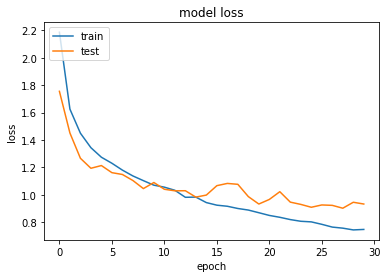

accuracy: 65.60%


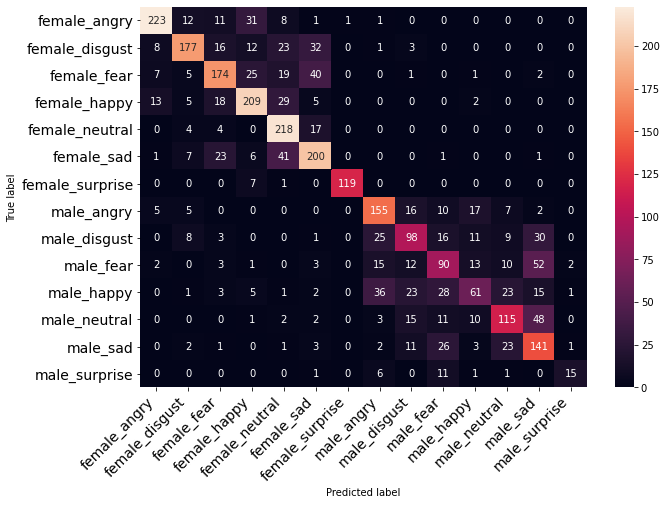

In [13]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

## OBSERVATION

### The model with MFCC as featurisation technique with no data augmentation has given an accuracy of 65.60% and the test loss is 0.9324. 
### This process has improved the model's score by ~ 20%.
### Both the train and test loss curve is smooth and some gap starts forming after 15th epoch. If we increase the epochs there are changes that the model will start overfitting.

#    

#   

In [21]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc_aug = prepare_data(ref, n = n_mfcc, aug = 1, mfcc = 1)

100%|██████████| 12162/12162 [16:33<00:00, 12.24it/s]


In [24]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc_aug
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=30)

Train on 9121 samples, validate on 3041 samples
Epoch 1/30
 - 300s - loss: 2.2597 - acc: 0.2384 - val_loss: 2.4140 - val_acc: 0.1947
Epoch 2/30
 - 257s - loss: 1.7886 - acc: 0.3852 - val_loss: 1.8389 - val_acc: 0.3683
Epoch 3/30
 - 256s - loss: 1.6022 - acc: 0.4422 - val_loss: 1.5103 - val_acc: 0.4623
Epoch 4/30
 - 256s - loss: 1.4819 - acc: 0.4762 - val_loss: 1.5813 - val_acc: 0.4834
Epoch 5/30
 - 256s - loss: 1.4243 - acc: 0.4980 - val_loss: 1.2609 - val_acc: 0.5432
Epoch 6/30
 - 256s - loss: 1.3509 - acc: 0.5222 - val_loss: 1.9411 - val_acc: 0.4015
Epoch 7/30
 - 256s - loss: 1.3003 - acc: 0.5406 - val_loss: 1.1918 - val_acc: 0.5788
Epoch 8/30
 - 256s - loss: 1.2702 - acc: 0.5433 - val_loss: 1.1646 - val_acc: 0.5801
Epoch 9/30
 - 256s - loss: 1.2285 - acc: 0.5650 - val_loss: 1.4368 - val_acc: 0.5340
Epoch 10/30
 - 258s - loss: 1.2085 - acc: 0.5597 - val_loss: 1.1110 - val_acc: 0.5919
Epoch 11/30
 - 256s - loss: 1.1850 - acc: 0.5718 - val_loss: 1.1924 - val_acc: 0.5649
Epoch 12/30
 - 

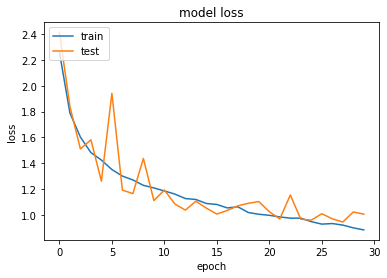

accuracy: 63.33%


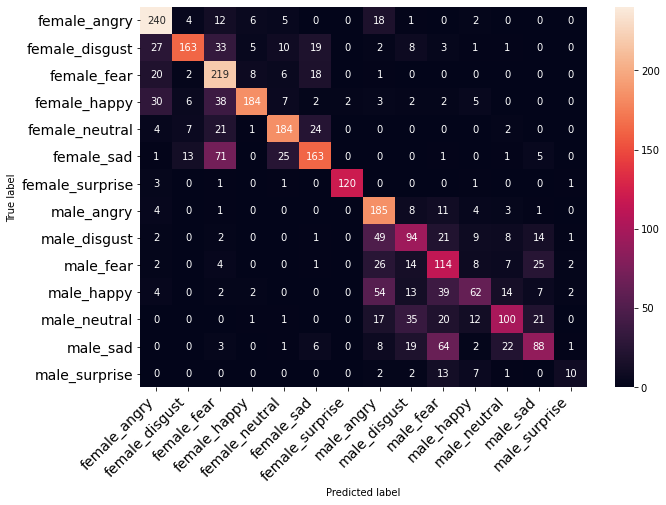

In [25]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

## OBSERVATION

### The model with MFCC as featurisation technique with data augmentation has given an accuracy of 63.33% and the test loss is 1.0054. 
### This process has improved the model's score by ~ 18%.
### This model when compared to the previous model is a little poor performing model.
### The test loss curve is fluctuating and increase in the number of epochs may not improve the model's performance.

#   

#   

In [18]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 60
specgram = prepare_data(ref, n = n_melspec, aug = 0, mfcc = 0)

100%|██████████| 12162/12162 [15:33<00:00, 13.03it/s]


In [19]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(specgram
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )



# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=30)

Train on 9121 samples, validate on 3041 samples
Epoch 1/30
 - 670s - loss: 2.3040 - acc: 0.2182 - val_loss: 2.0841 - val_acc: 0.2752
Epoch 2/30
 - 566s - loss: 1.9224 - acc: 0.3349 - val_loss: 1.8130 - val_acc: 0.3920
Epoch 3/30
 - 544s - loss: 1.6914 - acc: 0.4075 - val_loss: 1.5429 - val_acc: 0.4633
Epoch 4/30
 - 584s - loss: 1.5371 - acc: 0.4562 - val_loss: 1.4005 - val_acc: 0.4919
Epoch 5/30
 - 602s - loss: 1.4423 - acc: 0.4882 - val_loss: 1.3385 - val_acc: 0.5110
Epoch 6/30
 - 592s - loss: 1.3784 - acc: 0.5060 - val_loss: 1.2359 - val_acc: 0.5521
Epoch 7/30
 - 547s - loss: 1.3257 - acc: 0.5203 - val_loss: 1.2269 - val_acc: 0.5584
Epoch 8/30
 - 608s - loss: 1.2806 - acc: 0.5356 - val_loss: 1.2123 - val_acc: 0.5656
Epoch 9/30
 - 615s - loss: 1.2206 - acc: 0.5570 - val_loss: 1.1991 - val_acc: 0.5699
Epoch 10/30
 - 535s - loss: 1.2078 - acc: 0.5638 - val_loss: 1.1068 - val_acc: 0.5959
Epoch 11/30
 - 530s - loss: 1.1691 - acc: 0.5793 - val_loss: 1.0621 - val_acc: 0.6047
Epoch 12/30
 - 

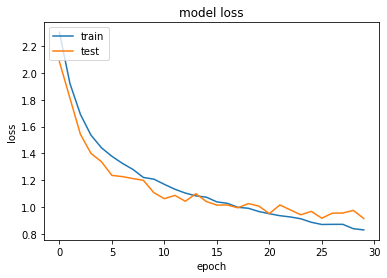

accuracy: 66.62%


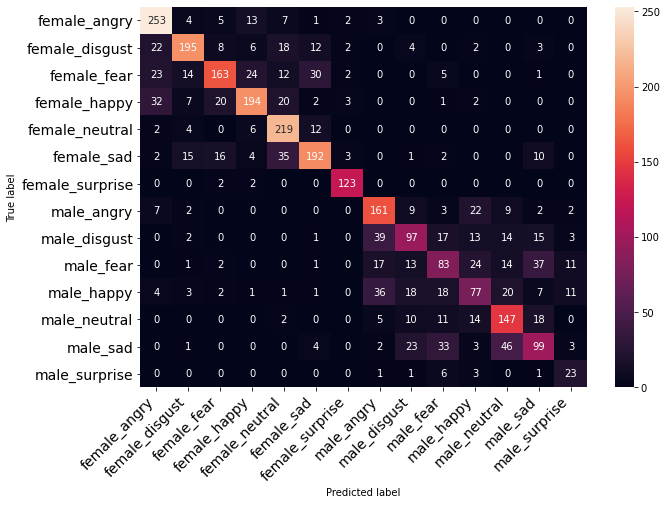

In [20]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

## OBSERVATION

### The model with Log-melspectogram as featurisation technique with data augmentation has given an accuracy of 66.62% and the test loss is 0.9142. 
### This process has improved the model's score by ~ 23%.
### This model when compared to the previous model is a little better performing model.
### The train and test loss are almost similar and increasing the number of epochs may help increasing the model's performance.

#    

#   

In [26]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 60
aug_specgram = prepare_data(ref,  n = n_melspec, aug = 1, mfcc = 0)

100%|██████████| 12162/12162 [16:26<00:00, 12.33it/s]


In [27]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(aug_specgram
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )



# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=30)

Train on 9121 samples, validate on 3041 samples
Epoch 1/30
 - 574s - loss: 2.2567 - acc: 0.2282 - val_loss: 2.0993 - val_acc: 0.2831
Epoch 2/30
 - 526s - loss: 1.8655 - acc: 0.3449 - val_loss: 1.9393 - val_acc: 0.3308
Epoch 3/30
 - 519s - loss: 1.7025 - acc: 0.4017 - val_loss: 1.4869 - val_acc: 0.4758
Epoch 4/30
 - 518s - loss: 1.6017 - acc: 0.4433 - val_loss: 1.4042 - val_acc: 0.5189
Epoch 5/30
 - 518s - loss: 1.5012 - acc: 0.4666 - val_loss: 1.3237 - val_acc: 0.5173
Epoch 6/30
 - 520s - loss: 1.4438 - acc: 0.4905 - val_loss: 1.3405 - val_acc: 0.5380
Epoch 7/30
 - 519s - loss: 1.3815 - acc: 0.5166 - val_loss: 1.2791 - val_acc: 0.5432
Epoch 8/30
 - 519s - loss: 1.3623 - acc: 0.5209 - val_loss: 1.2421 - val_acc: 0.5765
Epoch 9/30
 - 519s - loss: 1.3020 - acc: 0.5402 - val_loss: 1.1799 - val_acc: 0.5811
Epoch 10/30
 - 519s - loss: 1.2647 - acc: 0.5550 - val_loss: 1.1245 - val_acc: 0.5982
Epoch 11/30
 - 518s - loss: 1.2329 - acc: 0.5642 - val_loss: 1.1249 - val_acc: 0.6001
Epoch 12/30
 - 

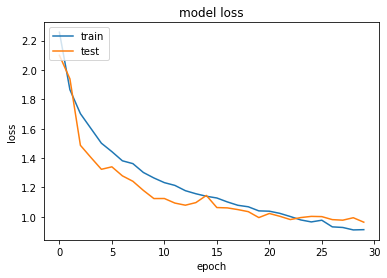

accuracy: 64.78%


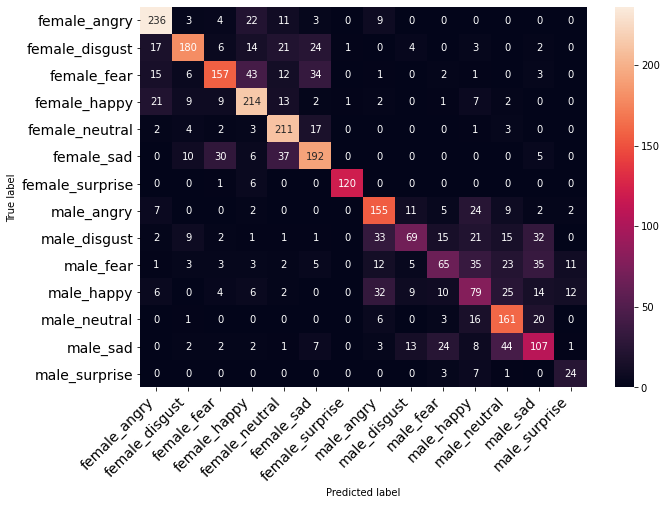

In [28]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

## OBSERVATION

### The model with Log-melspectogram as featurisation technique with data augmentation has given an accuracy of 64.78% and the test loss is 0.9637. 
### This process has improved the model's score by ~ 21%.
### This model when compared to the previous model is a little bad performing model.
### The train and test loss are almost similar and increasing the number of epochs may help increasing the model's performance.

In [4]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Featurisation Technique", "Data Augmentation", "Train Loss", "Test Loss", "Train Accuracy(in %)", "Test Accuracy(in %)"]

x.add_row(["MFCC", "No", 0.7468, 0.9324, 72.70, 65.60])
x.add_row(["MFCC", "Yes", 0.8834, 1.0054, 68.15, 63.33])
x.add_row(["Log-melspectogram", "No", 0.8290, 0.9142, 69.75, 66.62])
x.add_row(["Log-melspectogram", "Yes", 0.9129, 0.9637, 66.94, 64.78])

print(x)

+-------------------------+-------------------+------------+-----------+----------------------+---------------------+
| Featurisation Technique | Data Augmentation | Train Loss | Test Loss | Train Accuracy(in %) | Test Accuracy(in %) |
+-------------------------+-------------------+------------+-----------+----------------------+---------------------+
|           MFCC          |         No        |   0.7468   |   0.9324  |         72.7         |         65.6        |
|           MFCC          |        Yes        |   0.8834   |   1.0054  |        68.15         |        63.33        |
|    Log-melspectogram    |         No        |   0.829    |   0.9142  |        69.75         |        66.62        |
|    Log-melspectogram    |        Yes        |   0.9129   |   0.9637  |        66.94         |        64.78        |
+-------------------------+-------------------+------------+-----------+----------------------+---------------------+


# Conclusion

1) The best performing model is with Log-melspectogram featurisation technique without Data Augmentation.

2) From the result table above, Augmentation technique has not been helpful. This maybe because we have only used one augmentation technique.

3) We can also see that the model is performing well for emotions of Female and not as good for male emotions.

4) We trained the model with 30 epochs. The model's performance may improving if trained with greater number of epochs and more data augmentation.